# QOSF Task 2
-------------------------------
**1**. Encoding the following files in a quantum circuit mock_train_set.csv and mock_test_set.csv in at least two different ways (these could be basis, angle,  amplitude, kernel or random encoding).

**2**.Design a variational quantum circuit for each of the encodings, uses the column 4  as the target,  this is a binary class 0 and 1.

**3**.You must  use the data  from column0 to column3 for your proposed classifier. 

**4**.Consider the ansatz you are going to design as a layer and find out how many layers are necessary to reach the best performance.

## Overview
Our submission uses Principal Component Analysis(PCA) to reduce the dimensionality of the given data[3] so that we can use the minimum amount of qubits to train the quantum circuit. This provides us with the ability to run the training and testing faster than using all 3 components of the given data. In our submission we used Pennylane as the basis library to create and run our circuit[1].

### Let us begin:
First we import all of the required libraries:

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import GradientDescentOptimizer,AdamOptimizer,MomentumOptimizer
from sklearn.preprocessing import scale, normalize, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn.functional import relu
import random
import torch
import pandas as pd

Now, we can load the training data into a datafram so that we extract the raw data and the labels. We also also "scaled" the labels to fit between(-1,1). As you can see we are given 300 data points for training and we plotted the data points on a 3d scatter.

300 300


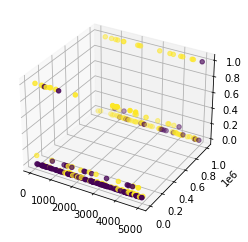

In [2]:
# Load Training Label
df = pd.read_csv (r'./mock_train_set.csv')
train_data = df.iloc[:,[i for i in range(4)]].to_numpy()
train_labels = df.iloc[:, 4].to_numpy()
train_labels = 2 * (train_labels - 0.5)
print(len(train_data), len(train_labels))
ax = plt.axes(projection ="3d")
ax.scatter3D(train_data[:,0], train_data[:,1], train_data[:,2], c=train_labels)
plt.show()

Next we shall perform PCA on the data to obtain the PCA components. In this case our k=2 so that we can reduce the number of qubits required for training. For k=2 the total explained variance ratio is 0.97 which indicates that 2 qubits is sufficient to for the circuit to learn the distribution of data points

In [3]:
# PCA on the dataset k >= 2 
k=2
pca = PCA(n_components=k)
train_data = normalize(train_data)
print("Loading Data....")
pca.fit(train_data)
print("Mean = ", pca.mean_)
print("Variance Ratio = ", sum(pca.explained_variance_ratio_))
print("Components = ", pca.components_)
X = pca.transform(train_data)
print(X)

Loading Data....
Mean =  [0.43745612 0.43749534 0.26010457 0.01411412]
Variance Ratio =  0.9795725972751432
Components =  [[ 0.73616305 -0.66623601 -0.11669772  0.02398289]
 [-0.29452935 -0.47138155  0.83124205 -0.00941005]]
[[ 0.46733506 -0.3145855 ]
 [-0.66380536 -0.35357292]
 [-0.39316998  0.30835536]
 [-0.1542951   0.88720685]
 [ 0.38422489  0.47016692]
 [ 0.55920792  0.31378472]
 [-0.55258649  0.37282143]
 [-0.11096038  0.94761805]
 [-0.12110213  0.94435469]
 [ 0.73546767 -0.17546636]
 [-0.55348261  0.37318003]
 [ 0.73545809 -0.17546338]
 [ 0.30977432 -0.32740286]
 [ 0.71709996 -0.16703269]
 [ 0.45659599 -0.29127431]
 [ 0.72910588 -0.16161742]
 [-0.66506063 -0.34518998]
 [ 0.73534881 -0.17539   ]
 [-0.59468026 -0.29441242]
 [ 0.46464133 -0.31835271]
 [-0.66626786 -0.34471064]
 [-0.55367805  0.37325822]
 [-0.55347378  0.37317649]
 [-0.66517894 -0.3451431 ]
 [ 0.56646813 -0.2723465 ]
 [ 0.12887612  0.71462848]
 [ 0.73213698 -0.15348972]
 [ 0.73492982 -0.17115605]
 [-0.01990129  0.81

Since the pca data points lie between -1,1, we need to scale them such that the points only lie between 0,1. This is done so data can be encoded as the distribution of points. Our encoding strategy utilises RY gates so the Arcsin of the of the data points will return the PCA values as the output probability of the qubits.

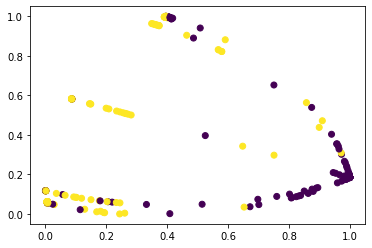

In [4]:
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
plt.scatter(X[:,0], X[:,1], c=train_labels)
plt.show()

In [5]:
# Convert the data into rotation angles.
pca_data = 2*np.arcsin(np.sqrt(X)) 
print(pca_data)

[[2.23868634 0.58561402]
 [0.17451265 0.47368171]
 [0.92603703 1.64058818]
 [1.3054511  2.71149436]
 [2.09608982 1.8800223 ]
 [2.41828633 1.64848086]
 [0.5968952  1.73472439]
 [1.3686354  3.05797236]
 [1.35393105 3.01324558]
 [3.11283838 0.88707148]
 [0.59463045 1.73525135]
 [3.11236981 0.88707706]
 [1.97782648 0.55108895]
 [2.91103107 0.90274386]
 [2.2194336  0.64420494]
 [3.00411319 0.9127055 ]
 [0.16394275 0.49966795]
 [3.10747549 0.88721427]
 [0.48046396 0.63659094]
 [2.23383    0.5756578 ]
 [0.15309719 0.50111642]
 [0.5941355  1.73536626]
 [0.5946528  1.73524615]
 [0.16291154 0.4998098 ]
 [2.43398275 0.6885992 ]
 [1.71059186 2.28992505]
 [3.04019006 0.92751473]
 [3.09308768 0.89510598]
 [1.49908484 2.51092309]
 [2.77268336 0.92241524]
 [3.12785512 0.8869053 ]
 [0.97496376 0.49349032]
 [1.37342251 2.96083791]
 [0.14324151 0.502349  ]
 [3.04988469 0.92213546]
 [1.9225112  0.38318259]
 [3.11118215 0.89113014]
 [0.59346602 1.73552158]
 [1.98485871 0.43729662]
 [0.14532399 0.50209521]


#### Creating the circuit
-----------------------
Now we have to create the circuit, our encoding circuit only use a single RY gate for each qubit following which will be the discrimnator circuit, which also utilises RY gates to learn the distribution of points[1,2].

In [6]:
dev = qml.device("default.qubit", wires=k)

In [7]:
def real(x_in_l):
#     qml.Rot(phi, theta, omega, wires=0)
    real_data_len = len(x_in_l)
    for i in range(real_data_len):
        qml.RY(x_in_l[i], wires=i)

In [8]:
def discriminator(w):
    W = np.reshape(w, (layers, k))
    for i in range(layers):
        for j in range(len(W[i])):
            qml.RY(W[i][j], wires=j)
        if i != layers-1:
            for l in range(1, len(W[i])):
                qml.CNOT(wires=[l-1, l])

In [9]:
# For real data set
@qml.qnode(dev,diff_method="parameter-shift")
def classifier_circuit(x_in_l, disc_weights):
    real(x_in_l)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(0))

In [10]:
def quantum_model(x_in_l, disc_weights):
    output = classifier_circuit(x_in_l, disc_weights)
    return output

def cost_function(x_in_l, disc_weights, train_labels):
    cost = 0   
    for i in range(len(x_in_l)):
        cost += abs(train_labels[i] - quantum_model(x_in_l[i], disc_weights))
#         cost += -1 * (np.log(1 - prob_fake_true(gen_weights, disc_weights)) + np.log(prob_real_true(x_in_l[i], disc_weights)))
    return cost / len(x_in_l)

def prediction_test(x_in_l, disc_weights):
    predictions = []
    for x in x_in_l:
        pred = quantum_model(x, disc_weights)
        if pred > 0:
            predictions.append(1.0)
        else:
            predictions.append(-1.0)
            
    return predictions

We now can initialize the required paramters for the circuit, we shall also use batch training, we decided on  having 15 samples per batch as it produces the best results. The initial training weights are also randomized. The current circuit would look like :

In [11]:
batch_size = 10
layers = 2
eps = 1e-2
opt = GradientDescentOptimizer(0.1)
disc_weights = np.random.normal(size=[k * layers])
drawer = qml.draw(classifier_circuit, max_length=100)
print(drawer(pca_data[0], disc_weights))

 0: ──RY(2.24)───RY(-0.955)──╭C──RY(-0.0725)──┤ ⟨Z⟩
 1: ──RY(0.586)──RY(0.28)────╰X──RY(-0.769)───┤    



Now we can finally begin the training cycle, with 20 epochs and we shall also save the loss values and plot them after the training is complete:

In [12]:
cost_Fn_loss = []
# trainin cycle loop:
epochs = 20
for ep in range(epochs):
    print("Starting Epoch : ", ep)
    
    # Train the discriminator first, lock the generator variables:
    disc_weights.requires_grad = True
    for i in range(0, len(pca_data), batch_size):
        if i + batch_size >= len(pca_data):
            x_in_l = np.array(pca_data[i: len(pca_data)], requires_grad=False)
            training_labels =np.array(train_labels[i: len(pca_data)], requires_grad=False)
        else:
            x_in_l = np.array(pca_data[i: i+batch_size], requires_grad=False)
            training_labels = np.array(train_labels[i: i+batch_size], requires_grad=False)
            
        x_in_l, disc_weights, training_labels = opt.step(cost_function, x_in_l, disc_weights, training_labels)
        cost = cost_function(x_in_l, disc_weights, training_labels)
        
        if i % 10 == 0:
            cost_Fn_loss.append(cost)
            print("Step {}: cost = {}".format(i + 1, cost))
            
    ran_test = random.sample(range(0, len(pca_data)), batch_size)       
    test_x = pca_data[ran_test]
    test_l = train_labels[ran_test]
    preds = prediction_test(test_x, disc_weights)
    print("Accuracy :", accuracy_score(preds, test_l))
    
    # Shuffle Input data    
    pca_data, train_labels = shuffle(pca_data, train_labels)

Starting Epoch :  0
Step 1: cost = 0.6580102968669282
Step 11: cost = 0.7502451914738973
Step 21: cost = 0.3115972493703193
Step 31: cost = 0.5728666596780225
Step 41: cost = 0.47160317398523866
Step 51: cost = 0.4977988124297116
Step 61: cost = 0.5619874814183369
Step 71: cost = 0.48565161148982144
Step 81: cost = 0.21726369855340555
Step 91: cost = 0.2902274375261894
Step 101: cost = 0.1514109031248383
Step 111: cost = 0.4424338884841382
Step 121: cost = 0.7841722219921117
Step 131: cost = 0.3122879889228153
Step 141: cost = 0.4049594233093199
Step 151: cost = 0.5894724201308597
Step 161: cost = 0.47204885874198765
Step 171: cost = 0.1945186422567045
Step 181: cost = 0.30337663745122356
Step 191: cost = 0.2973737618302891
Step 201: cost = 0.7564178919047972
Step 211: cost = 0.7731105230810463
Step 221: cost = 0.4262599969057743
Step 231: cost = 0.4754931260095832
Step 241: cost = 0.965818269396312
Step 251: cost = 0.34274473441019404
Step 261: cost = 0.6502598267514511
Step 271: cost

Step 131: cost = 0.8053471588940923
Step 141: cost = 0.532574771783249
Step 151: cost = 0.24705800025162494
Step 161: cost = 0.28513279501150335
Step 171: cost = 0.9015776038310234
Step 181: cost = 0.6008814693153754
Step 191: cost = 0.7071761734584097
Step 201: cost = 0.43365533545569007
Step 211: cost = 0.9267671451718714
Step 221: cost = 0.2646903680681869
Step 231: cost = 0.10503171547059802
Step 241: cost = 0.28580445917640673
Step 251: cost = 0.7836168336048506
Step 261: cost = 0.30965637142080793
Step 271: cost = 0.09807371837684754
Step 281: cost = 0.40225048587851714
Step 291: cost = 0.3953341232498929
Accuracy : 0.8
Starting Epoch :  8
Step 1: cost = 0.6769064170285302
Step 11: cost = 0.23946824418049234
Step 21: cost = 0.7488851901469207
Step 31: cost = 0.465315130979908
Step 41: cost = 0.1727124490857106
Step 51: cost = 0.4187265951226416
Step 61: cost = 0.32941842685302614
Step 71: cost = 0.267858191942498
Step 81: cost = 0.028690291324712867
Step 91: cost = 0.846162532798

Step 251: cost = 0.26886117276820803
Step 261: cost = 0.5032037472858024
Step 271: cost = 0.47419109067237697
Step 281: cost = 0.25037013843018296
Step 291: cost = 0.3130096647039044
Accuracy : 0.9
Starting Epoch :  15
Step 1: cost = 0.21210842550330505
Step 11: cost = 0.6729423352515688
Step 21: cost = 0.5276959370606493
Step 31: cost = 0.4306690554073541
Step 41: cost = 0.45058173536882495
Step 51: cost = 0.28106220113402
Step 61: cost = 0.3474477769273342
Step 71: cost = 0.4725077590187309
Step 81: cost = 0.4470504242738295
Step 91: cost = 0.3804741638451319
Step 101: cost = 0.1475768737934138
Step 111: cost = 0.5501155425255608
Step 121: cost = 0.19618852250442348
Step 131: cost = 0.4235214909036956
Step 141: cost = 0.6368369334957426
Step 151: cost = 0.5427911038888739
Step 161: cost = 0.5383895755300034
Step 171: cost = 0.07679739135277838
Step 181: cost = 0.6982339914749269
Step 191: cost = 0.15551478099296898
Step 201: cost = 0.4121813655504103
Step 211: cost = 0.19860498038087

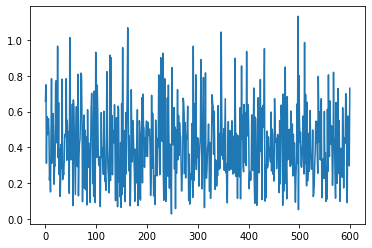

In [13]:
plt.plot(range(len(cost_Fn_loss)), cost_Fn_loss)
plt.show()

Now that the training is complete, we can test our classifier and see how well it does for the test data set. But first lets take a look at the test data set:

120 120


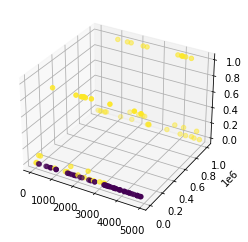

In [14]:
# Load Test Data
df = pd.read_csv (r'./mock_test_set.csv')
test_data = df.iloc[:,[i for i in range(4)]].to_numpy()
test_labels = df.iloc[:, 4].to_numpy()
test_labels = 2 * (test_labels - 0.5)
print(len(test_data), len(test_labels))

ax = plt.axes(projection ="3d")
ax.scatter3D(test_data[:,0], test_data[:,1], test_data[:,2], c=test_labels)
plt.show()

Loading Data....
Mean =  [0.43745612 0.43749534 0.26010457 0.01411412]
Variance Ratios =  0.9795725972751432
Components =  [[ 0.73616305 -0.66623601 -0.11669772  0.02398289]
 [-0.29452935 -0.47138155  0.83124205 -0.00941005]]


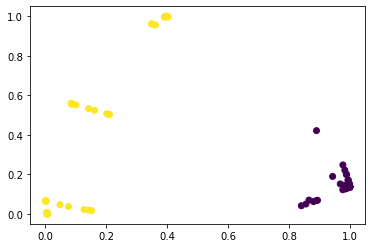

In [15]:
pca_test = PCA(n_components=k)
test_data = normalize(test_data)
print("Loading Data....")
pca_test.fit(test_data)
print("Mean = ", pca.mean_)

print("Variance Ratios = ", sum(pca.explained_variance_ratio_))
print("Components = ", pca.components_)
X_test = pca.transform(test_data)
scaler = MinMaxScaler()
scaler.fit(X_test)
X_test = scaler.transform(X_test)
pca_test = 2*np.arcsin(np.sqrt(X_test))


plt.scatter(X_test[:,0], X_test[:,1],c=test_labels)
plt.show()

The test data is definately easier to classify than the training set, as the difference in the data points are rather obvious nonetheless we shall how our classifier does:

In [16]:
predictions = prediction_test(pca_test, disc_weights)
accuracy_score(predictions, test_labels)

1.0

As you can see, our classifier did rather well in learning the distribution of points, but this can alos be attributed to the fact that the test points given was relatively simple.

##### References:
1. PennyLane Demo: https://pennylane.ai/qml/demos/tutorial_state_preparation.html
2. Quantum Tensorflow Tutorial: https://www.tensorflow.org/quantum/tutorials/mnist
3. QuGAN: A Quantum State Fidelity based Generative Adversarial Network: https://arxiv.org/pdf/2010.09036.pdf